In [1]:
!pip install prophet pystan --upgrade

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA

from prophet import Prophet

In [3]:
df = pd.read_csv("/content/DailyDelhiClimateTrain.csv")

df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)

df.head()

,meantemp,humidity,wind_speed,meanpressure
date,,,,
2013-01-01,10.000000,84.500000,0.000000,1015.666667
2013-01-02,7.400000,92.000000,2.980000,1017.800000
2013-01-03,7.166667,87.000000,4.633333,1018.666667
2013-01-04,8.666667,71.333333,1.233333,1017.166667
2013-01-05,6.000000,86.833333,3.700000,1016.500000


Date Range: 2013-01-01 00:00:00 → 2017-01-01 00:00:00

Columns:
 Index(['meantemp', 'humidity', 'wind_speed', 'meanpressure'], dtype='object')

Missing Values:
 meantemp        0
humidity        0
wind_speed      0
meanpressure    0
dtype: int64


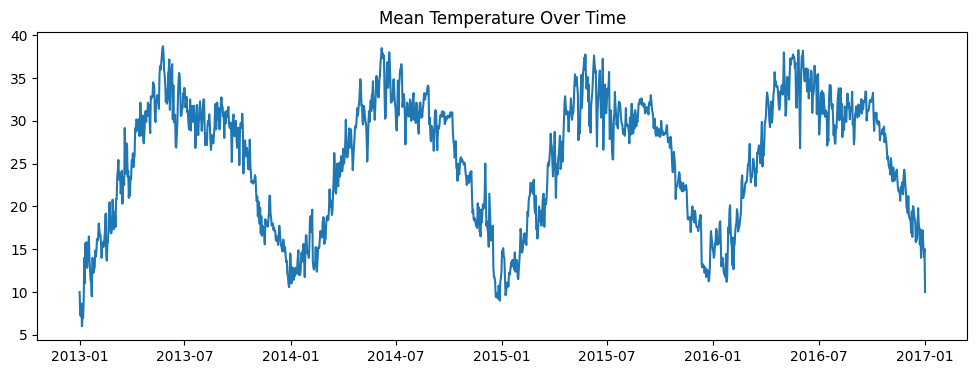

In [4]:
print("Date Range:", df.index.min(), "→", df.index.max())
print("\nColumns:\n", df.columns)
print("\nMissing Values:\n", df.isnull().sum())

plt.figure(figsize=(12,4))
plt.plot(df['meantemp'])
plt.title("Mean Temperature Over Time")
plt.show()


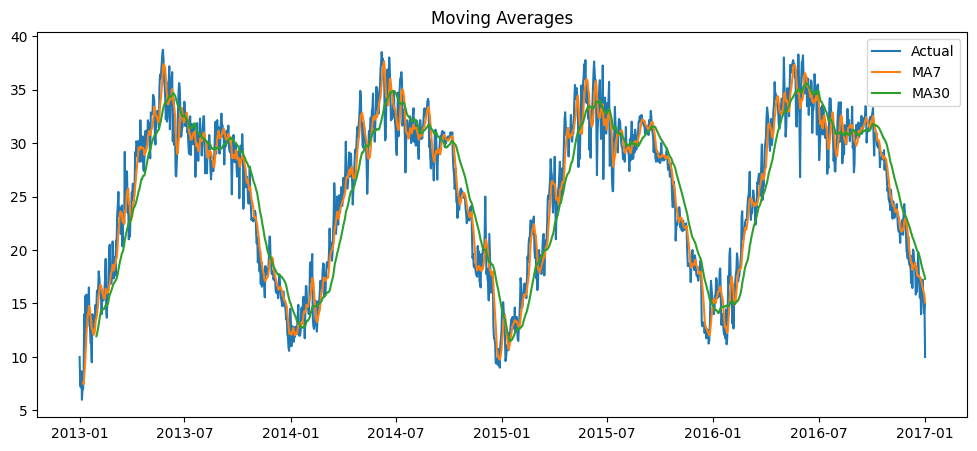

In [5]:
df['MA7'] = df['meantemp'].rolling(7).mean()
df['MA30'] = df['meantemp'].rolling(30).mean()

plt.figure(figsize=(12,5))
plt.plot(df['meantemp'], label='Actual')
plt.plot(df['MA7'], label='MA7')
plt.plot(df['MA30'], label='MA30')
plt.title("Moving Averages")
plt.legend()
plt.show()


In [6]:
result = adfuller(df['meantemp'].dropna())

print("ADF Statistic :", result[0])
print("p-value       :", result[1])

for key, val in result[4].items():
    print(f"Critical Value {key} : {val}")


ADF Statistic : -2.021069055920673
p-value       : 0.2774121372301602
Critical Value 1% : -3.4348647527922824
Critical Value 5% : -2.863533960720434
Critical Value 10% : -2.567831568508802


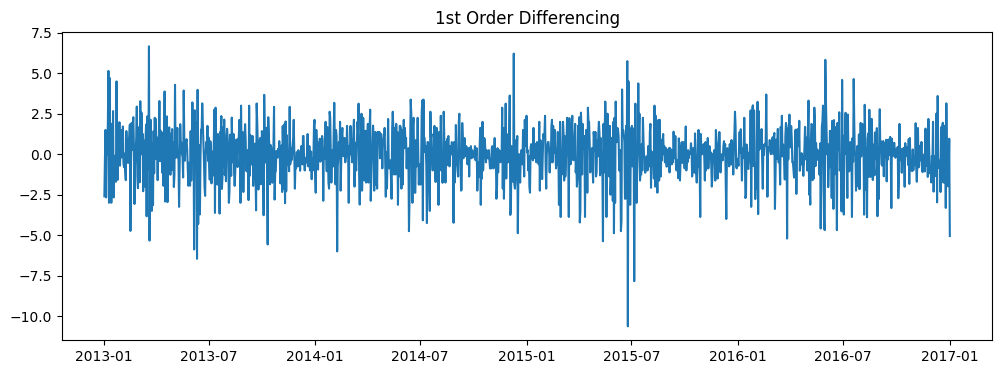

In [7]:
df['diff'] = df['meantemp'].diff()

plt.figure(figsize=(12,4))
plt.plot(df['diff'])
plt.title("1st Order Differencing")
plt.show()


<Figure size 1200x400 with 0 Axes>

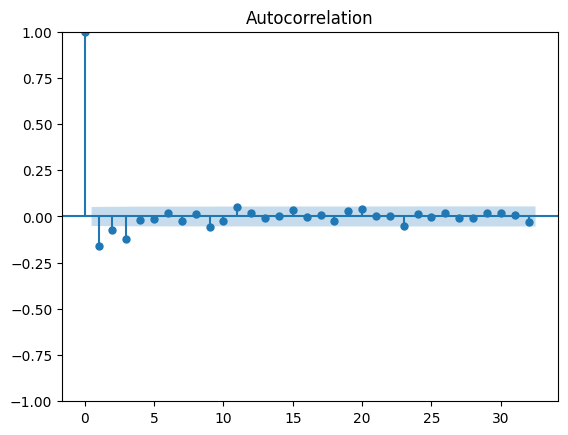

<Figure size 1200x400 with 0 Axes>

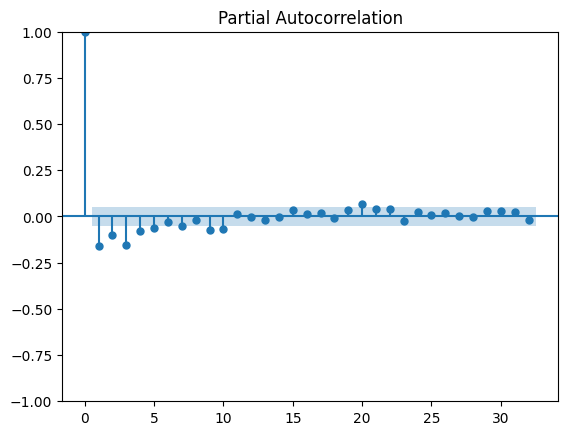

In [8]:
plt.figure(figsize=(12,4))
plot_acf(df['diff'].dropna())
plt.show()

plt.figure(figsize=(12,4))
plot_pacf(df['diff'].dropna())
plt.show()


In [9]:
model = ARIMA(df['meantemp'], order=(2,1,2))
arima_result = model.fit()

print(arima_result.summary())

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:               meantemp   No. Observations:                 1462
Model:                 ARIMA(2, 1, 2)   Log Likelihood               -2767.166
Date:                Sat, 15 Nov 2025   AIC                           5544.332
Time:                        15:36:48   BIC                           5570.767
Sample:                    01-01-2013   HQIC                          5554.193
                         - 01-01-2017                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2627      0.198     -1.327      0.185      -0.651       0.125
ar.L2          0.5043      0.098      5.136      0.000       0.312       0.697
ma.L1          0.0231      0.200      0.116      0.9

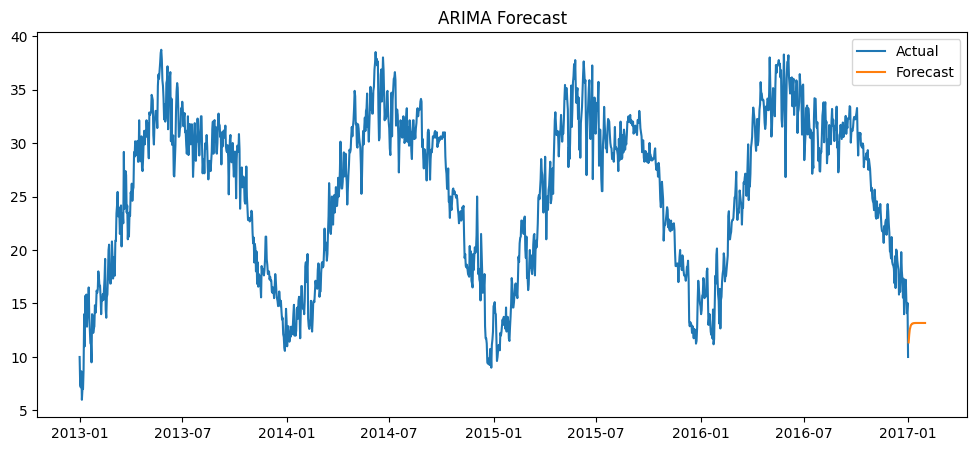

In [10]:
forecast_arima = arima_result.forecast(steps=30)

plt.figure(figsize=(12,5))
plt.plot(df['meantemp'], label='Actual')
plt.plot(forecast_arima.index, forecast_arima.values, label='Forecast')
plt.title("ARIMA Forecast")
plt.legend()
plt.show()


In [11]:
df_prophet = df.reset_index()[['date', 'meantemp']]
df_prophet = df_prophet.rename(columns={'date':'ds', 'meantemp':'y'})

df_prophet.head()


,ds,y
0,2013-01-01,10.000000
1,2013-01-02,7.400000
2,2013-01-03,7.166667
3,2013-01-04,8.666667
4,2013-01-05,6.000000


In [12]:
model_p = Prophet(daily_seasonality=True)
model_p.fit(df_prophet)

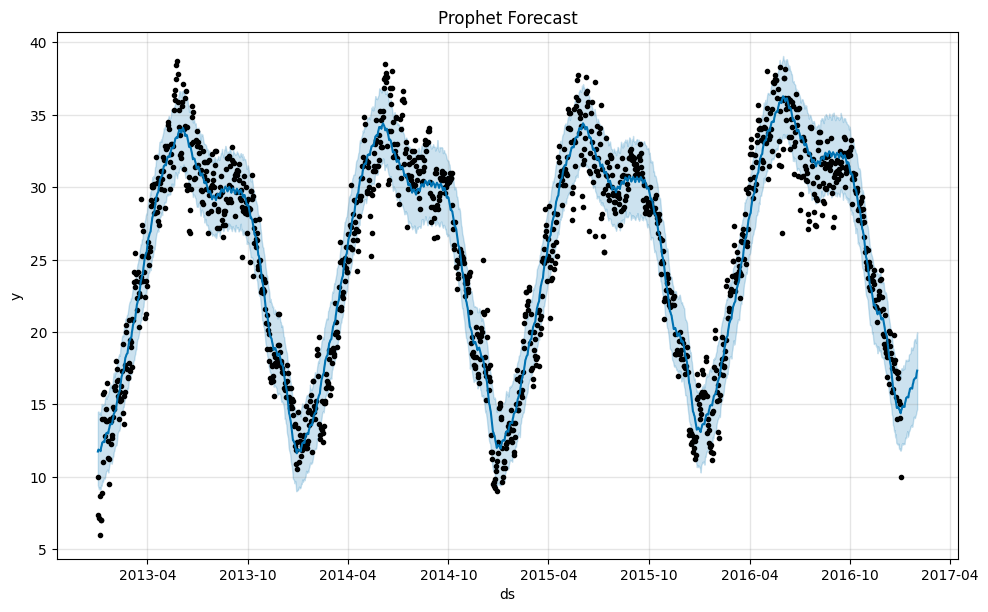

In [13]:
future = model_p.make_future_dataframe(periods=30)
forecast_p = model_p.predict(future)

model_p.plot(forecast_p)
plt.title("Prophet Forecast")
plt.show()


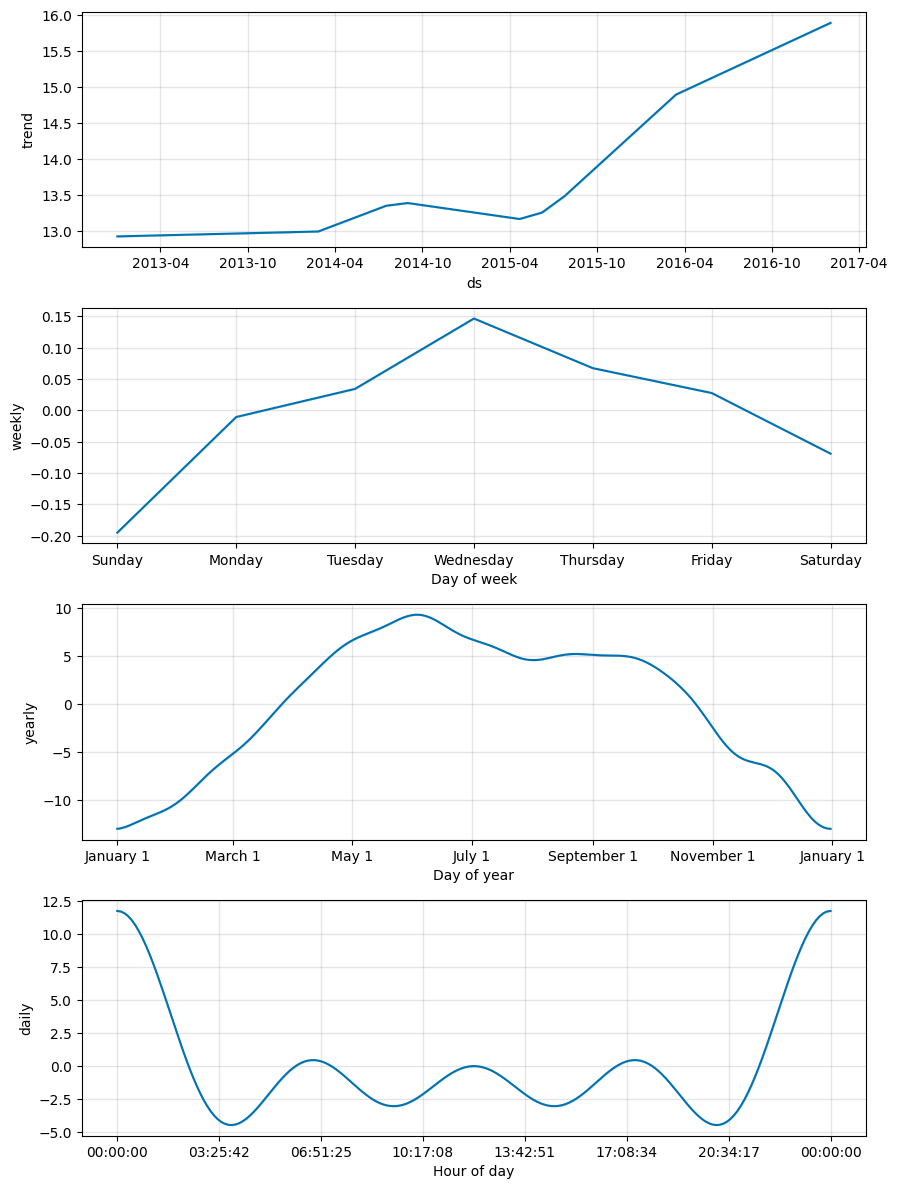

In [14]:
model_p.plot_components(forecast_p)
plt.show()


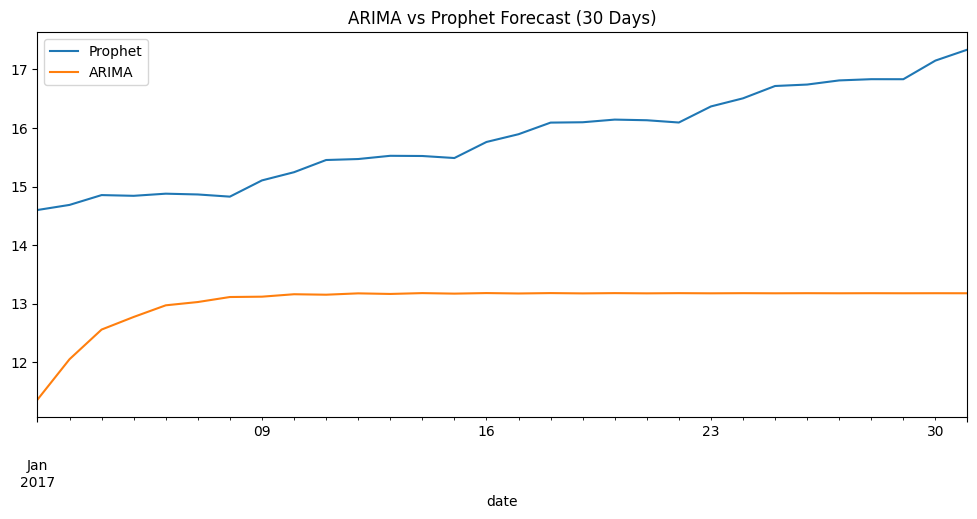

,Prophet,ARIMA
date,,
2017-01-02,14.599913,11.363143
2017-01-03,14.686900,12.053028
2017-01-04,14.854499,12.559183
2017-01-05,14.842061,12.774101
2017-01-06,14.878410,12.972879


In [15]:
comparison = pd.DataFrame({
    "date": forecast_p['ds'].iloc[-30:],
    "Prophet": forecast_p['yhat'].iloc[-30:].values,
    "ARIMA": forecast_arima.values
})

comparison.set_index('date', inplace=True)
comparison.plot(figsize=(12,5), title="ARIMA vs Prophet Forecast (30 Days)")
plt.show()

comparison.head()


### 🔥 Week 16 Reflection

- ARIMA strengths:
- Prophet strengths:
- Where I struggled:
- What improved:
- What to revise next time:
